In [239]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df = pd.read_csv("C:/Users/Kofidence/Desktop/wfp_food_prices_uga.csv")

In [240]:
df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2006-01-15,Busia,Samia-bugwe,Busia,0.467,34.09,cereals and tubers,Maize,KG,actual,Wholesale,UGX,298.4,0.1641
2,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,UGX,345.42,0.19
3,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,UGX,1013.4,0.5573
4,2006-01-15,Lira,Lira Municipality,Lira,2.235,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,UGX,247.76,0.1362


In [241]:
# dropping a range of rows containing forecast price(0.0); from it's start to it's end
df = df.drop(df.index[15417:16505])

#dropping the first row
df = df.drop(0)

#dropping the columns which are not required
df = df.drop(['admin1', 'admin2','unit', 'priceflag', 'currency', 'usdprice'], axis=1)

In [242]:
# dividing the dataset into two; wholesale price only and retail price only
wholesale_df = df[df['pricetype']=='Wholesale'].reset_index(drop=True)
retail_df = df[df['pricetype']=='Retail'].reset_index(drop=True)

#deleting the the pricetype column
del retail_df["pricetype"]

In [243]:
# Filter for cereals and tubers category
cereal_tuber_retail_df = retail_df[retail_df['category'] == 'cereals and tubers'].copy()



In [244]:
cereal_tuber_retail_df['commodity'].value_counts()

Maize flour        1709
Maize (white)      1585
Sorghum            1520
Cassava flour      1257
Millet             1037
Millet flour        331
Cassava (fresh)     279
Maize               187
Name: commodity, dtype: int64

In [245]:
# Filter for cereals and tubers category
cereal_tuber_retail_df = retail_df[retail_df['category'] == 'cereals and tubers'].copy()

# Filter for Owino market
owino = cereal_tuber_retail_df[cereal_tuber_retail_df['market'] == 'Owino'].copy()
lira = cereal_tuber_retail_df[cereal_tuber_retail_df['market'] == 'Lira'].copy()
gulu = cereal_tuber_retail_df[cereal_tuber_retail_df['market'] == 'Gulu'].copy()
mbarara = cereal_tuber_retail_df[cereal_tuber_retail_df['market'] == 'Mbarara'].copy()

# Dropping redundant columns
owino = owino.drop(['category', 'market', 'latitude', 'longitude'], axis=1)

owino_sorghum = owino[owino["commodity"] == "Sorghum"].reset_index(drop=True)
owino_cassava = owino[owino["commodity"] == "Cassava flour"].reset_index(drop=True)
owino_maize = owino[owino["commodity"] == "Maize flour"].reset_index(drop=True)

# Deleting the commodity column
del owino_sorghum['commodity']
del owino_cassava['commodity']
del owino_maize['commodity']

# Converting price column to float
owino_sorghum['price'] = owino_sorghum['price'].astype(float)
owino_cassava['price'] = owino_cassava['price'].astype(float)
owino_maize['price'] = owino_maize['price'].astype(float)

# Obtaining the dataset for Lira market
lira = lira.drop(['category', 'market', 'latitude', 'longitude'], axis=1)

lira_sorghum = lira[lira["commodity"] == "Sorghum"].reset_index(drop=True)
lira_cassava = lira[lira["commodity"] == "Cassava flour"].reset_index(drop=True)
lira_maize = lira[lira["commodity"] == "Maize flour"].reset_index(drop=True)

# Deleting the commodity column
del lira_sorghum['commodity']
del lira_cassava['commodity']
del lira_maize['commodity']

# Converting price column to float
lira_sorghum['price'] = lira_sorghum['price'].astype(float)
lira_cassava['price'] = lira_cassava['price'].astype(float)
lira_maize['price'] = lira_maize['price'].astype(float)

# Obtaining the dataset for Gulu market
gulu = gulu.drop(['category', 'market', 'latitude', 'longitude'], axis=1)

gulu_sorghum = gulu[gulu["commodity"] == "Sorghum"].reset_index(drop=True)
gulu_cassava = gulu[gulu["commodity"] == "Cassava flour"].reset_index(drop=True)
gulu_maize = gulu[gulu["commodity"] == "Maize flour"].reset_index(drop=True)

# Deleting the commodity column
del gulu_sorghum['commodity']
del gulu_cassava['commodity']
del gulu_maize['commodity']

# Converting price column to float
gulu_sorghum['price'] = gulu_sorghum['price'].astype(float)
gulu_cassava['price'] = gulu_cassava['price'].astype(float)
gulu_maize['price'] = gulu_maize['price'].astype(float)

# Obtaining the dataset for the Mbarara market
mbarara = mbarara.drop(['category', 'market', 'latitude', 'longitude'], axis=1)

mbarara_sorghum = mbarara[mbarara["commodity"] == "Sorghum"].reset_index(drop=True)
mbarara_cassava = mbarara[mbarara["commodity"] == "Cassava flour"].reset_index(drop=True)
mbarara_maize = mbarara[mbarara["commodity"] == "Maize flour"].reset_index(drop=True)

# Deleting the commodity column
del mbarara_sorghum['commodity']
del mbarara_cassava['commodity']
del mbarara_maize['commodity']

# Converting price column to float
mbarara_sorghum['price'] = mbarara_sorghum['price'].astype(float)
mbarara_cassava['price'] = mbarara_cassava['price'].astype(float)
mbarara_maize['price'] = mbarara_maize['price'].astype(float)


In [246]:
#setting the date as the index column
owino_sorghum = owino_sorghum.set_index('date')
owino_cassava = owino_cassava.set_index('date')
owino_maize = owino_maize.set_index('date')

#converting the date to datetime
owino_sorghum.index=pd.to_datetime(owino_sorghum.index)
owino_cassava.index=pd.to_datetime(owino_cassava.index)
owino_maize.index=pd.to_datetime(owino_maize.index)

# Set the date as the index column
lira_sorghum = lira_sorghum.set_index('date')
lira_cassava = lira_cassava.set_index('date')
lira_maize = lira_maize.set_index('date')

# Convert the date to datetime
lira_sorghum.index = pd.to_datetime(lira_sorghum.index)
lira_cassava.index = pd.to_datetime(lira_cassava.index)
lira_maize.index = pd.to_datetime(lira_maize.index)

# Set the date as the index column
gulu_sorghum = gulu_sorghum.set_index('date')
gulu_cassava = gulu_cassava.set_index('date')
gulu_maize = gulu_maize.set_index('date')

# Convert the date to datetime
gulu_sorghum.index = pd.to_datetime(gulu_sorghum.index)
gulu_cassava.index = pd.to_datetime(gulu_cassava.index)
gulu_maize.index = pd.to_datetime(gulu_maize.index)

# Set the date as the index column
mbarara_sorghum = mbarara_sorghum.set_index('date')
mbarara_cassava = mbarara_cassava.set_index('date')
mbarara_maize = mbarara_maize.set_index('date')

# Convert the date to datetime
mbarara_sorghum.index = pd.to_datetime(mbarara_sorghum.index)
mbarara_cassava.index = pd.to_datetime(mbarara_cassava.index)
mbarara_maize.index = pd.to_datetime(mbarara_maize.index)

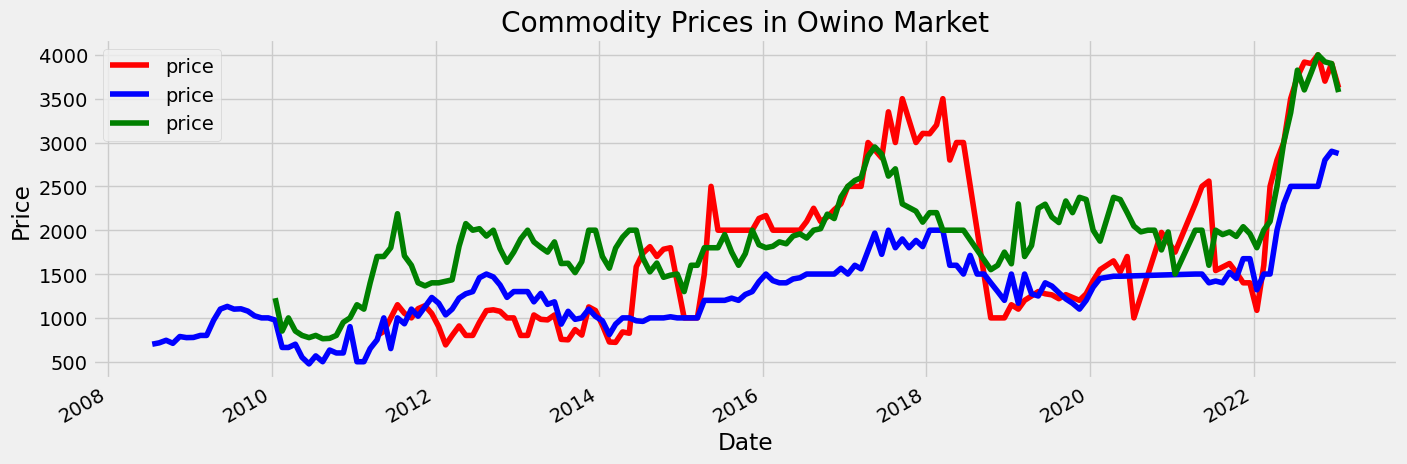

In [247]:
import matplotlib.pyplot as plt

# Assuming you have the data for each commodity (owino_beans, owino_cassava, owino_maize)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting each commodity data with different colors and labels
owino_sorghum.plot(ax=ax, color='red', label='Sorghum')
owino_cassava.plot(ax=ax, color='blue', label='Cassava')
owino_maize.plot(ax=ax, color='green', label='Maize')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Commodity Prices in Owino Market')

# Add a legend
ax.legend()

# Display the plot
plt.show()



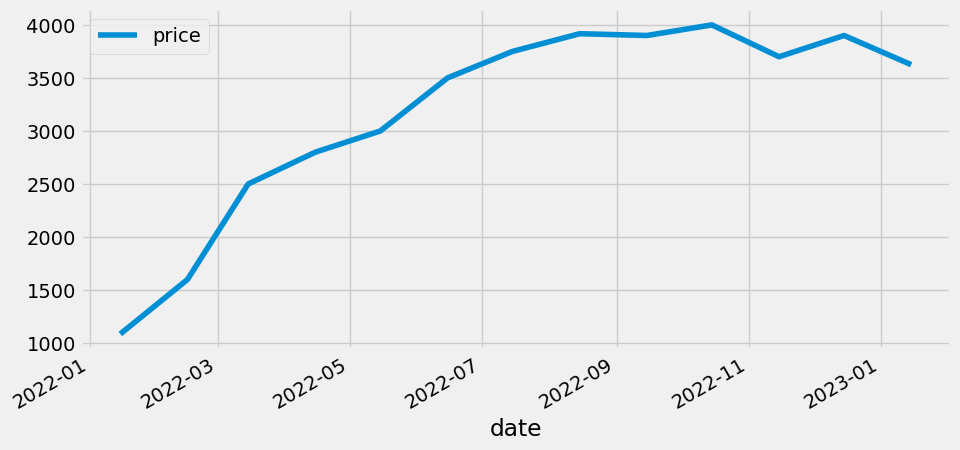

In [248]:
#monthly price distribution
filtered_df = owino_sorghum.loc[
    (owino_sorghum.index >= '2022-01-15') &
    (owino_sorghum.index <= '2023-01-15')
]

filtered_df.plot(figsize=(10, 5))
plt.show()

In [249]:
#feature creation
def feature_creation_and_add_lags(data):
    data = data.copy()
    data["dayofweek"] = data.index.dayofweek
    data["quarter"] = data.index.quarter
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["dayofmonth"] = data.index.day
    data["weekofyear"] = data.index.isocalendar().week
    
    target_map = data['price'].to_dict()
    data['lag1'] = (data.index - pd.Timedelta('365 days')).map(target_map)
    data['lag2'] = (data.index - pd.Timedelta('730 days')).map(target_map)
    
    return data

#owino
owino_sorghum = feature_creation_and_add_lags(owino_sorghum)
owino_cassava = feature_creation_and_add_lags(owino_cassava)
owino_maize = feature_creation_and_add_lags(owino_maize)

#lira
lira_sorghum = feature_creation_and_add_lags(lira_sorghum)
lira_cassava = feature_creation_and_add_lags(lira_cassava)
lira_maize = feature_creation_and_add_lags(lira_maize)

#gulu
gulu_sorghum = feature_creation_and_add_lags(gulu_sorghum)
gulu_cassava = feature_creation_and_add_lags(gulu_cassava)
gulu_maize = feature_creation_and_add_lags(gulu_maize)

#mbarara
mbarara_sorghum = feature_creation_and_add_lags(mbarara_sorghum)
mbarara_cassava = feature_creation_and_add_lags(mbarara_cassava)
mbarara_maize = feature_creation_and_add_lags(mbarara_maize)

In [250]:
lira_maize

,price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2
date,,,,,,,,,,
2010-01-15,1725.0,4,1,1,2010,15,15,2,NaN,NaN
2010-02-15,1750.0,0,1,2,2010,46,15,7,NaN,NaN
2010-03-15,1750.0,0,1,3,2010,74,15,11,NaN,NaN
2010-04-15,1625.0,3,2,4,2010,105,15,15,NaN,NaN
2010-05-15,1587.5,5,2,5,2010,135,15,19,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-09-15,3167.0,3,3,9,2022,258,15,37,1800.0,1715.0
2022-10-15,3375.0,5,4,10,2022,288,15,41,1950.0,1888.0
2022-11-15,2960.0,1,4,11,2022,319,15,46,1860.0,1411.0


In [251]:
#training the model
def train_model(data, commodity):
    data_train = data.copy()
    data_train = feature_creation_and_add_lags(data_train)

    FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'dayofmonth', 'year', 'lag1', 'lag2']
    TARGET = 'price'

    X_train = data_train[FEATURES]
    y_train = data_train[TARGET]

    tss = TimeSeriesSplit(n_splits=3, test_size=30)

    fold = 0
    preds = []
    scores = []

    for train_idx, val_idx in tss.split(data_train):
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                               n_estimators=1000,
                               early_stopping_rounds=50,
                               objective='reg:linear',
                               max_depth=3,
                               learning_rate=0.01)

        reg.fit(X_train_fold, y_train_fold,
                eval_set=[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)],
                verbose=100)

        preds_fold = reg.predict(X_val_fold)
        preds.append(preds_fold)
        score = np.sqrt(mean_squared_error(y_val_fold, preds_fold))
        scores.append(score)

    print(f"Commodity: {commodity}")
    print("Average RMSE:", np.mean(scores))
    
    return reg

# Sort the data owino
owino_sorghum = owino_sorghum.sort_index()
owino_cassava = owino_cassava.sort_index()
owino_maize = owino_maize.sort_index()

# Sort the data lira
lira_sorghum = lira_sorghum.sort_index()
lira_cassava = lira_cassava.sort_index()
lira_maize = lira_maize.sort_index()

# Sort the data gulu
gulu_sorghum = gulu_sorghum.sort_index()
gulu_cassava = gulu_cassava.sort_index()
gulu_maize = gulu_maize.sort_index()

# Sort the data mbarara
mbarara_sorgum = mbarara_sorghum.sort_index()
mbarara_cassava = mbarara_cassava.sort_index()
mbarara_maize = mbarara_maize.sort_index()

# Train models for each commodity in owino
reg_sorghum_owino = train_model(owino_sorghum, "Sorghum")
reg_cassava_owino = train_model(owino_cassava, "Cassava")
reg_maize_owino = train_model(owino_maize, "Maize")

# Train models for each commodity in lira
reg_sorghum_lira = train_model(lira_sorghum, "Sorghum")
reg_cassava_lira = train_model(lira_cassava, "Cassava")
reg_maize_lira = train_model(lira_maize, "Maize")

# Train models for each commodity in gulu
reg_sorghum_gulu = train_model(gulu_sorghum, "Sorghum")
reg_cassava_gulu = train_model(gulu_cassava, "Cassava")
reg_maize_gulu = train_model(gulu_maize, "Maize")

# Train models for each commodity in mbarara
reg_sorghum_mbarara = train_model(mbarara_sorghum, "Sorghum")
reg_cassava_mbarara = train_model(mbarara_cassava, "Cassava")
reg_maize_mbarara = train_model(mbarara_maize, "Maize")

[14:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1005.32832	validation_1-rmse:2003.28934
[100]	validation_0-rmse:421.62582	validation_1-rmse:1376.63323
[200]	validation_0-rmse:204.04708	validation_1-rmse:1193.84097
[300]	validation_0-rmse:115.25107	validation_1-rmse:1105.28675
[400]	validation_0-rmse:75.22713	validation_1-rmse:1063.34159
[500]	validation_0-rmse:56.34690	validation_1-rmse:1051.26180
[600]	validation_0-rmse:45.55715	validation_1-rmse:1044.49400
[700]	validation_0-rmse:40.47438	validation_1-rmse:1041.70092
[800]	validation_0-rmse:36.86277	validation_1-rmse:1040.69180
[900]	validation_0-rmse:32.87145	validation_1-rmse:1039.60499
[999]	validation_0-rmse:29.81188	validation_1-rmse:1039.45735
[14:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-grou

[200]	validation_0-rmse:141.59778	validation_1-rmse:309.48390
[300]	validation_0-rmse:77.63809	validation_1-rmse:262.62244
[378]	validation_0-rmse:58.42427	validation_1-rmse:263.79801
[14:54:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:866.62315	validation_1-rmse:1078.85737
[100]	validation_0-rmse:357.75909	validation_1-rmse:572.87309
[200]	validation_0-rmse:180.19692	validation_1-rmse:413.17112
[300]	validation_0-rmse:119.73664	validation_1-rmse:381.82747
[400]	validation_0-rmse:96.02421	validation_1-rmse:368.98112
[464]	validation_0-rmse:86.83091	validation_1-rmse:368.71855
Commodity: Sorghum
Average RMSE: 314.93058812590874
[14:54:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.

[100]	validation_0-rmse:903.52503	validation_1-rmse:2266.26020
[200]	validation_0-rmse:458.44125	validation_1-rmse:1854.90882
[300]	validation_0-rmse:310.59243	validation_1-rmse:1693.73970
[400]	validation_0-rmse:252.64731	validation_1-rmse:1611.95631
[500]	validation_0-rmse:219.19380	validation_1-rmse:1568.73448
[600]	validation_0-rmse:195.82178	validation_1-rmse:1547.46106
[700]	validation_0-rmse:174.99121	validation_1-rmse:1536.49443
[800]	validation_0-rmse:157.40979	validation_1-rmse:1528.90034
[900]	validation_0-rmse:143.81452	validation_1-rmse:1523.52763
[999]	validation_0-rmse:132.10801	validation_1-rmse:1517.25392
[14:54:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2582.81504	validation_1-rmse:3086.12700
[100]	validation_0-rmse:1113.77140	validation_1-rmse:1321.26771
[200]	validat

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:56:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2364145424.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:56:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2140454566.py", line 77, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:56:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\338704048.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:56:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\208276062.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:56:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1424193084.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:56:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1867438990.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:56:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3766346207.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:56:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:56:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\4190643304.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

[700]	validation_0-rmse:48.99596	validation_1-rmse:379.53473
[800]	validation_0-rmse:43.56370	validation_1-rmse:378.24219
[900]	validation_0-rmse:36.94584	validation_1-rmse:376.87910
[999]	validation_0-rmse:32.87013	validation_1-rmse:375.90819
[14:55:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1556.73220	validation_1-rmse:2076.64295
[100]	validation_0-rmse:622.51619	validation_1-rmse:1093.48613
[200]	validation_0-rmse:266.51180	validation_1-rmse:806.57341
[300]	validation_0-rmse:133.66952	validation_1-rmse:714.44597
[400]	validation_0-rmse:87.10965	validation_1-rmse:669.26866
[500]	validation_0-rmse:70.64521	validation_1-rmse:649.01533
[593]	validation_0-rmse:63.11249	validation_1-rmse:649.38809
[14:55:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593

[14:55:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1967.80325
[100]	validation_0-rmse:830.21146
[200]	validation_0-rmse:403.82459
[300]	validation_0-rmse:252.47467
[400]	validation_0-rmse:197.13993
[499]	validation_0-rmse:169.91629
[14:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1362.30221
[100]	validation_0-rmse:543.42965
[200]	validation_0-rmse:244.43805
[300]	validation_0-rmse:144.28660
[400]	validation_0-rmse:111.64566
[499]	validation_0-rmse:98.27472
[14:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-window

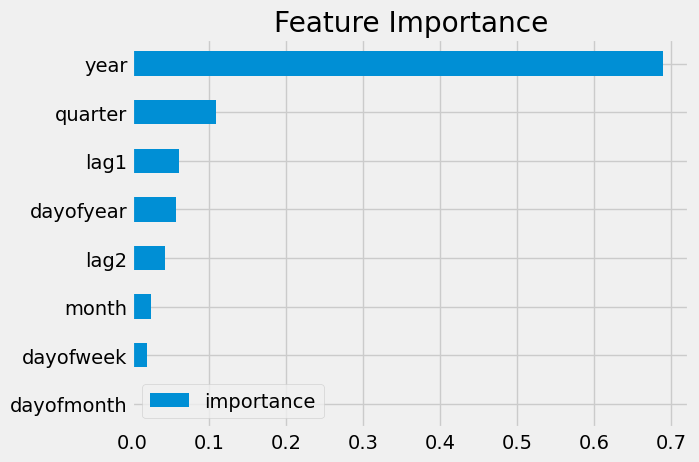

In [252]:
#retraining the model
import xgboost as xgb
import pickle
import pandas as pd
import matplotlib.pyplot as plt

def train_model(data, commodity):
    data = feature_creation_and_add_lags(data)

    FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'dayofmonth', 'year', 'lag1', 'lag2']
    TARGET = 'price'

    X_all = data[FEATURES]
    y_all = data[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=500,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)

    reg.fit(X_all, y_all,
            eval_set=[(X_all, y_all)],
            verbose=100)

    # Saving the model as a pickle file
    with open(f'trained_model_{commodity}.pkl', 'wb') as f:
        pickle.dump(reg, f)
    
    return reg

# Train models for each commodity and get the trained models for owino
model_sorghum_owino = train_model(owino_sorghum, "Sorghum")
model_cassava_owino = train_model(owino_cassava, "Cassava")
model_maize_owino = train_model(owino_maize, "Maize")

# Train models for each commodity and get the trained models for gulu
model_sorghum_gulu = train_model(gulu_sorghum, "Sorghum")
model_cassava_gulu = train_model(gulu_cassava, "Cassava")
model_maize_gulu = train_model(gulu_maize, "Maize")

# Train models for each commodity and get the trained models for lira
model_sorghum_lira = train_model(lira_sorghum, "Sorghum")
model_cassava_lira = train_model(lira_cassava, "Cassava")
model_maize_lira = train_model(lira_maize, "Maize")

# Train models for each commodity and get the trained models for mbarara
model_sorghum_mbarara = train_model(mbarara_sorghum, "Sorghum")
model_cassava_mbarara = train_model(mbarara_cassava, "Cassava")
model_maize_mbarara = train_model(mbarara_maize, "Maize")

# Plot feature importances for each model
def plot_feature_importance(model, features):
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

# Define FEATURES here
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'dayofmonth', 'year', 'lag1', 'lag2']

plot_feature_importance(model_maize_mbarara, FEATURES)
plt.show()

In [253]:
#feature creation
commodities = ['Sorghum', 'Cassava', 'Maize']
locations = ['owino', 'lira', 'gulu', 'mbarara']
dataframes = {}

def create_future_dataframe():
    future = pd.date_range('2023-01-15', '2024-01-15', freq='M') + pd.DateOffset(days=15)
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    return future_df

def process_location_data(location):
    for commodity in commodities:
        df = globals()[f'{location}_{commodity.lower()}'].copy()
        future_df = create_future_dataframe()

        df_combined = pd.concat([df, future_df])
        df_combined = feature_creation_and_add_lags(df_combined)

        future_data = df_combined.query('isFuture == True').copy()
        dataframes[commodity] = future_data

def access_dataframes(location):
    for commodity in commodities:
        dataframes[f'{commodity.lower()}_future_{location}'] = dataframes[commodity]

# Process data for each location
for location in locations:
    process_location_data(location)
    access_dataframes(location)

# Access the individual future dataframes
#owino
sorghum_future_owino = dataframes['sorghum_future_owino']
cassava_future_owino = dataframes['cassava_future_owino']
maize_future_owino = dataframes['maize_future_owino']

#lira
sorghum_future_lira = dataframes['sorghum_future_lira']
cassava_future_lira = dataframes['cassava_future_lira']
maize_future_lira = dataframes['maize_future_lira']

#gulu
sorghum_future_gulu = dataframes['sorghum_future_gulu']
cassava_future_gulu = dataframes['cassava_future_gulu']
maize_future_gulu = dataframes['maize_future_gulu']

#mbarara
sorghum_future_mbarara = dataframes['sorghum_future_mbarara']
cassava_future_mbarara = dataframes['cassava_future_mbarara']
maize_future_mbarara = dataframes['maize_future_mbarara']

In [254]:
maize_future_mbarara

,price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture
2023-02-15,NaN,2,1,2,2023,46,15,7,2000.0,NaN,True
2023-03-15,NaN,2,1,3,2023,74,15,11,2375.0,NaN,True
2023-04-15,NaN,5,2,4,2023,105,15,15,2600.0,1600.0,True
2023-05-15,NaN,0,2,5,2023,135,15,20,2929.0,1800.0,True
2023-06-15,NaN,3,2,6,2023,166,15,24,3071.0,2000.0,True
2023-07-15,NaN,5,3,7,2023,196,15,28,3875.0,2000.0,True
2023-08-15,NaN,1,3,8,2023,227,15,33,3750.0,1800.0,True
2023-09-15,NaN,4,3,9,2023,258,15,37,3900.0,1907.0,True
2023-10-15,NaN,6,4,10,2023,288,15,41,4000.0,2007.0,True
2023-11-15,NaN,2,4,11,2023,319,15,46,4200.0,2071.0,True


In [255]:
# Filter Monthly_future DataFrame for '2023-01-15'
prediction_date = pd.to_datetime('2023-02-15')

#owino
prediction_sorghum_owino = sorghum_future_owino[sorghum_future_owino.index == prediction_date].copy()
prediction_cassava_owino = cassava_future_owino[cassava_future_owino.index == prediction_date].copy()
prediction_maize_owino = maize_future_owino[maize_future_owino.index == prediction_date].copy()

#lira
prediction_sorghum_lira = sorghum_future_lira[sorghum_future_lira.index == prediction_date].copy()
prediction_cassava_lira = cassava_future_lira[cassava_future_lira.index == prediction_date].copy()
prediction_maize_lira = maize_future_lira[maize_future_lira.index == prediction_date].copy()

#gulu
prediction_sorghum_gulu = sorghum_future_gulu[sorghum_future_gulu.index == prediction_date].copy()
prediction_cassava_gulu = cassava_future_gulu[cassava_future_gulu.index == prediction_date].copy()
prediction_maize_gulu = maize_future_gulu[maize_future_gulu.index == prediction_date].copy()

#mbarara
prediction_sorghum_mbarara = sorghum_future_mbarara[sorghum_future_mbarara.index == prediction_date].copy()
prediction_cassava_mbarara = cassava_future_mbarara[cassava_future_mbarara.index == prediction_date].copy()
prediction_maize_mbarara = maize_future_mbarara[maize_future_mbarara.index == prediction_date].copy()

# Making prediction for 2023-02-15 using the trained model
#owino
prediction_sorghum_owino['predicts'] = reg_sorghum_owino.predict(prediction_sorghum_owino[FEATURES])
prediction_cassava_owino['predicts'] = reg_cassava_owino.predict(prediction_cassava_owino[FEATURES])
prediction_maize_owino['predicts'] = reg_maize_owino.predict(prediction_maize_owino[FEATURES])

#lira
prediction_sorghum_lira['predicts'] = reg_sorghum_lira.predict(prediction_sorghum_lira[FEATURES])
prediction_cassava_lira['predicts'] = reg_cassava_lira.predict(prediction_cassava_lira[FEATURES])
prediction_maize_lira['predicts'] = reg_maize_lira.predict(prediction_maize_lira[FEATURES])

#gulu
prediction_sorghum_gulu['predicts'] = reg_sorghum_gulu.predict(prediction_sorghum_gulu[FEATURES])
prediction_cassava_gulu['predicts'] = reg_cassava_gulu.predict(prediction_cassava_gulu[FEATURES])
prediction_maize_gulu['predicts'] = reg_maize_gulu.predict(prediction_maize_gulu[FEATURES])

#mbarara
prediction_sorghum_mbarara['predicts'] = reg_sorghum_mbarara.predict(prediction_sorghum_mbarara[FEATURES])
prediction_cassava_mbarara['predicts'] = reg_cassava_mbarara.predict(prediction_cassava_mbarara[FEATURES])
prediction_maize_mbarara['predicts'] = reg_maize_mbarara.predict(prediction_maize_mbarara[FEATURES])

In [256]:
prediction_maize_gulu

,price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture,predicts
2023-02-15,NaN,2,1,2,2023,46,15,7,1617.0,NaN,True,2104.63623


In [257]:
#Future prediction
cassava_future_gulu['preds'] = reg_cassava_gulu.predict(cassava_future_gulu[FEATURES])

In [258]:
#Predicted result
cassava_future_gulu

,price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,isFuture,preds
2023-02-15,NaN,2,1,2,2023,46,15,7,3000.0,NaN,True,3003.144531
2023-03-15,NaN,2,1,3,2023,74,15,11,3000.0,NaN,True,3003.144531
2023-04-15,NaN,5,2,4,2023,105,15,15,3000.0,1500.0,True,3003.144531
2023-05-15,NaN,0,2,5,2023,135,15,20,3000.0,1500.0,True,3197.217773
2023-06-15,NaN,3,2,6,2023,166,15,24,3000.0,1600.0,True,3197.217773
2023-07-15,NaN,5,3,7,2023,196,15,28,NaN,3000.0,True,2781.847900
2023-08-15,NaN,1,3,8,2023,227,15,33,3000.0,3000.0,True,3198.817627
2023-09-15,NaN,4,3,9,2023,258,15,37,3000.0,3000.0,True,3265.750244
2023-10-15,NaN,6,4,10,2023,288,15,41,3000.0,3000.0,True,3275.119141
2023-11-15,NaN,2,4,11,2023,319,15,46,3000.0,3000.0,True,3282.690918


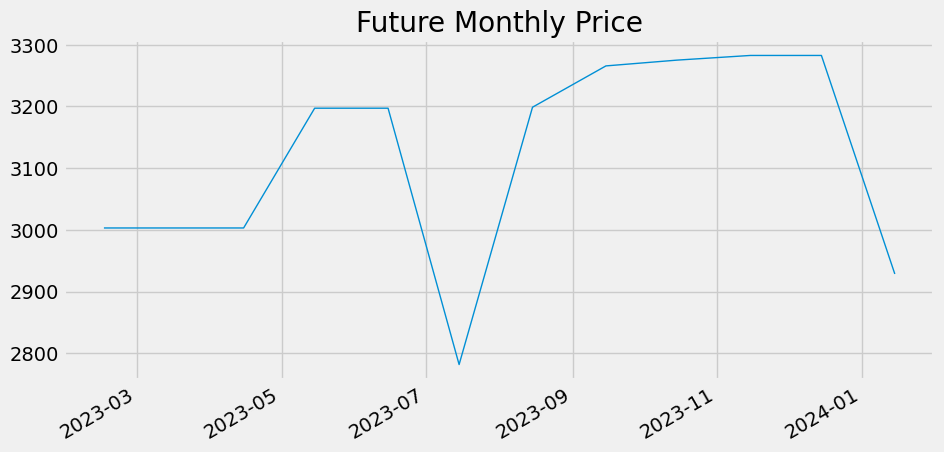

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:57:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2364145424.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:57:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1590099825.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:57:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3709432685.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:57:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2364145424.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:57:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1822910795.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:57:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\149729648.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:57:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2305762609.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:57:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1867438990.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:57:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:58:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\485144298.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:58:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3319520062.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:58:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2305762609.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:58:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\4221349318.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:58:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\149729648.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:58:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2807756520.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:58:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:58:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\4190643304.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:58:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3766346207.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

In [259]:
#result visualisation

cassava_future_gulu['preds'].plot(figsize=(10, 5),
                            ms=1,
                            lw=1,
                            title='Future Monthly Price')

plt.show()

In [ ]:
from flask import Flask, render_template, url_for, flash, redirect
from flask import Flask
from flask_wtf import FlaskForm
from wtforms import StringField, SubmitField, PasswordField, SubmitField,SelectField,DateField
from wtforms.validators import DataRequired, email_validator, Length, EqualTo
from datetime import datetime
import feedparser
from apscheduler.schedulers.background import BackgroundScheduler
import smtplib
from flask_mail import Message, Mail
import os





from flask_mysqldb import MySQL



app = Flask(__name__, static_url_path='/static')
app.config['SECRET_KEY'] = "CTKDANTE"
app.config['MY_SQL HOST'] = "localhost"
app.config['MYSQL_USER'] = "root"
app.config['MYSQL_PASSWORD'] = "dante"
app.config['MYSQL_DB'] = "users_db"

mail = Mail(app)

db = MySQL(app)



# creating the form class
class signupForm(FlaskForm):
    firstName = StringField('Enter Name', validators=[DataRequired(), Length(min=2, max=50)])
    secondName = StringField(validators=[DataRequired(), Length(min=2, max=50)])
    email = StringField('Enter email', validators=[DataRequired()])
    phoneNumber = StringField('Enter Number', validators=[DataRequired(), Length(min=10, max=13)])
    password = PasswordField('Enter password', validators=[DataRequired()])
    confirm_password = PasswordField('Confirm passord', validators=[DataRequired(), EqualTo('password')])
    submit = SubmitField('Register')


#creating another for class for user input
class user_input(FlaskForm):
    commodity = SelectField('Choose commodity to forecast', choices=[
        ('Sorghum', 'Sorghum'), ('Maize', 'Maize'), ('Cassava', 'Cassava')
    ])

    #forecasted_date = DateField('Enter Date to forecast', format="%Y-%m-%d")
    forecasted_date = SelectField('Choose Month in which to forecast', choices=[('2023-02-15', 'Febuary'), ('2023-03-15', 'March'), ('2023-04-15', 'April'), ('2023-05-15', 'May'), ('2023-06-15', 'June'), 
    ('2023-07-15', 'July'), ('2023-08-15', 'August'), ('2023-09-15', 'September'), ('2023-10-15', 'October'), ('2023-11-15', 'November'), ('2023-12-15', 'December')])
    
    submit = SubmitField('Forecast')
    
def sendmail():
    with app.app_context():
        email = "elitecs256@gmail.com"
        message = Message("Price Alerts", recipients=[email], sender='price4cast@gmail.com')
        message.subject = 'Alerts for this Month!'
        message.body = 'These are our price our prices for this month'

        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
    
        server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
        server.sendmail('price4cast@gmail.com', email, message.as_string())
#creating a scheduler that sends emails
email_scheduler = BackgroundScheduler()
email_scheduler.add_job(sendmail, 'interval', minutes=1, start_date='2023-07-14 17:35:00')
# # Start the scheduler
email_scheduler.start()
   

#index.html absolute path
directory = os.path.abspath('index.html')

@app.route('/')
def index():
    return render_template('index.html')
   

@app.route('/index')
def index1():
    return render_template('index.html')

#signup route
@app.route('/sign_up', methods=['GET', 'POST'])
def sign_up():
    
    form = signupForm()
    

    if form.validate_on_submit():
        print("Form validation successful")
        firstName = form.firstName.data
        secondName = form.secondName.data
        email = form.email.data
        phoneNumber =form.phoneNumber.data
        password = form.password.data
        password2 = form.confirm_password.data
        date_added = datetime.utcnow()

        
        

        cur = db.connection.cursor()
        cur.execute("SELECT email FROM user_info WHERE email = %s", (email,))
        existing_email = cur.fetchone()

        if existing_email:
            flash("email already exists")
        else:   
            cur.execute(" INSERT INTO user_info (FirstName, SecondName, email, phoneNumber,password, date_added ) VALUES (%s,%s,%s,%s,%s,%s)", (firstName, secondName, email, phoneNumber, password,date_added ))
            db.connection.commit()
            cur.close()
            return redirect(url_for('trends'))
        
    else: flash(form.errors)


        
           
    
    return render_template('sign_up.html',  
    form = form)

@app.route('/Forecast', methods = ['GET', 'POST']) 
def forecast():
    form = user_input()
    commodity_heading = ('', 'Owino', 'Lira', 'Gulu', 'Mbarara')
    choice = 0
    x = None  # Declare the variable outside the if condition

    if form.validate_on_submit():
        choice = form.commodity.data
        date_choice = form.forecasted_date.data
        prediction_date = pd.to_datetime(date_choice)

        if choice == 'Sorghum':
            prediction_owino = sorghum_future_owino[sorghum_future_owino.index == prediction_date]
            prediction_lira = sorghum_future_lira[sorghum_future_lira.index == prediction_date]
            prediction_gulu = sorghum_future_gulu[sorghum_future_gulu.index == prediction_date]
            prediction_mbarara = sorghum_future_mbarara[sorghum_future_mbarara.index == prediction_date]
            prediction_owino['predicts'] = reg_sorghum_owino.predict(prediction_owino[FEATURES])
            prediction_lira['predicts'] = reg_sorghum_lira.predict(prediction_lira[FEATURES])
            prediction_gulu['predicts'] = reg_sorghum_gulu.predict(prediction_gulu[FEATURES])
            prediction_mbarara['predicts'] = reg_sorghum_mbarara.predict(prediction_mbarara[FEATURES])
            month = str([prediction_owino['predicts'].values[0], prediction_lira['predicts'].values[0], prediction_gulu['predicts'].values[0], prediction_mbarara['predicts'].values[0]])
        elif choice == 'Cassava':
            prediction_owino = cassava_future_owino[cassava_future_owino.index == prediction_date]
            prediction_lira = cassava_future_lira[cassava_future_lira.index == prediction_date]
            prediction_gulu = cassava_future_gulu[cassava_future_gulu.index == prediction_date]
            prediction_mbarara = cassava_future_mbarara[cassava_future_mbarara.index == prediction_date]
            prediction_owino['predicts'] = reg_cassava_owino.predict(prediction_owino[FEATURES])
            prediction_lira['predicts'] = reg_cassava_lira.predict(prediction_lira[FEATURES])
            prediction_gulu['predicts'] = reg_cassava_gulu.predict(prediction_gulu[FEATURES])
            prediction_mbarara['predicts'] = reg_cassava_mbarara.predict(prediction_mbarara[FEATURES])
            month = str([prediction_owino['predicts'].values[0], prediction_lira['predicts'].values[0], prediction_gulu['predicts'].values[0], prediction_mbarara['predicts'].values[0]])
        elif choice == 'Maize':
            prediction_owino = maize_future_owino[maize_future_owino.index == prediction_date]
            prediction_lira = maize_future_lira[maize_future_lira.index == prediction_date]
            prediction_gulu = maize_future_gulu[maize_future_gulu.index == prediction_date]
            prediction_mbarara = maize_future_mbarara[maize_future_mbarara.index == prediction_date]
            prediction_owino['predicts'] = reg_maize_owino.predict(prediction_owino[FEATURES])
            prediction_lira['predicts'] = reg_maize_lira.predict(prediction_lira[FEATURES])
            prediction_gulu['predicts'] = reg_maize_gulu.predict(prediction_gulu[FEATURES])
            prediction_mbarara['predicts'] = reg_maize_mbarara.predict(prediction_mbarara[FEATURES])
            month = str([prediction_owino['predicts'].values[0], prediction_lira['predicts'].values[0], prediction_gulu['predicts'].values[0], prediction_mbarara['predicts'].values[0]])
        else:
            flash('Invalid choice')
            return redirect(url_for('forecast'))

        flash('Here is your forecast of ' + choice + ' for date ' + date_choice + ' is ' + month)
        print(choice + " is for month " + date_choice + ' is ' + month)

        x = month  # Assign the value of month to x within the if block

        condition = True
    else:
        condition = False

    # Use the value of x here outside the if condition
    print("Value of x: ", x)

    owino_price_1 = ""
    owino_price_2 = ""
    owino_price_3 = ""
    owino_price_4 = ""
    if x is not None:
        owino = [int(float(item)) for item in eval(x)]
        if len(owino) >= 1:
            owino_price_1 = owino[0]
        if len(owino) >= 2:
            owino_price_2 = owino[1]
        if len(owino) >= 3:
            owino_price_3 = owino[2]
        if len(owino) >= 4:
            owino_price_4 = owino[3]

    return render_template('Forecast.html', form=form, condition=condition,
                           commodity_heading=commodity_heading, choice=choice,
                           labels=label, values_flour=values_flour,
                           values_beans=values_beans, values_sugar=values_sugar,
                           values_rice=values_rice, owino_price_1=owino_price_1,
                           owino_price_2=owino_price_2, owino_price_3=owino_price_3,
                           owino_price_4=owino_price_4, lowest_prx1=lowest_prx1)


#Trends route
@app.route('/Dashboard')
def trends():
    sendmail()
    return render_template('Dashboard.html')

#'About us' Route
@app.route('/about')
def about():
    return render_template('about.html')

#Data for prices
data = [
        ("January", 1597, 2045, 3564, 4837),
        ("Febuary", 1497, 2090, 3932, 4276),
        ("March", 1580, 2500, 3048, 4091),
        ("April", 2197, 2600, 3019, 4849),
        ("May", 1550, 2700, 3782, 4092),
        ("June", 1297,2000, 3892, 4823),
        ("July", 1597, 1956, 3649, 4104),
        ("August", 1527, 2020, 3892, 4824),
        ("September", 1697, 1500, 3820, 4024),
        ("October", 1530, 2300, 3672, 4034),
        ("November", 1545, 2400, 3732, 4783),
        ("December", 1559, 1900, 3313, 4013),

    ]
label = [row[0] for row in data]

# For Maize

# # owino
# maize_future_owino['index'] = maize_future_owino.index
# maize_future_owino = maize_future_owino[['index', 'preds']].values.tolist()

# # lira
# maize_future_lira['index'] = maize_future_lira.index
# maize_future_lira = maize_future_lira[['index', 'preds']].values.tolist()

# # gulu
# maize_future_gulu['index'] = maize_future_gulu.index
# maize_future_gulu = maize_future_gulu[['index', 'preds']].values.tolist()

# # mbarara
# maize_future_mbarara['index'] = maize_future_mbarara.index
# maize_future_mbarara = maize_future_mbarara[['index', 'preds']].values.tolist()


# # For Cassava

# # owino
# cassava_future_owino['index'] = cassava_future_owino.index
# cassava_future_owino = cassava_future_owino[['index', 'preds']].values.tolist()

# # lira
# cassava_future_lira['index'] = cassava_future_lira.index
# cassava_future_lira = cassava_future_lira[['index', 'preds']].values.tolist()

# # gulu
# cassava_future_gulu['index'] = cassava_future_gulu.index
# cassava_future_gulu = cassava_future_gulu[['index', 'preds']].values.tolist()

# # mbarara
# cassava_future_mbarara['index'] = cassava_future_mbarara.index
# cassava_future_mbarara = cassava_future_mbarara[['index', 'preds']].values.tolist()


# # For Sorghum

# # owino
# sorghum_future_owino['index'] = sorghum_future_owino.index
# sorghum_future_owino = sorghum_future_owino[['index', 'preds']].values.tolist()

# # lira
# sorghum_future_lira['index'] = sorghum_future_lira.index
# sorghum_future_lira = sorghum_future_lira[['index', 'preds']].values.tolist()

# # gulu
# sorghum_future_gulu['index'] = sorghum_future_gulu.index
# sorghum_future_gulu = sorghum_future_gulu[['index', 'preds']].values.tolist()

# # mbarara
# sorghum_future_mbarara['index'] = sorghum_future_mbarara.index
# sorghum_future_mbarara = sorghum_future_mbarara[['index', 'preds']].values.tolist()


# #sorghum
# values_sorghum_owino = [row[1] for row in sorghum_future_owino]
# values_sorghum_lira =  [row[2] for row in sorghum_future_lira]
# values_sorghum_gulu = [row[3] for row in sorghum_future_gulu]
# values_sorghum_mbarara = [row[4] for row in sorghum_future_mbarara]

# #cassava
# values_cassava_owino = [row[1] for row in cassava_future_owino]
# values_cassava_lira = [row[2] for row in cassava_future_lira]
# values_cassava_gulu = [row[3] for row in cassava_future_gulu]
# values_cassava_mbarara = [row[4] for row in cassava_future_mbarara]

# #maize
# values_maize_owino = [row[1] for row in maize_future_owino]
# values_maize_lira = [row[2] for row in maize_future_lira]
# values_maize_gulu = [row[3] for row in maize_future_gulu]
# values_maize_mbarara = [row[4] for row in maize_future_mbarara]

#dummy overall
values_flour = [row[1] for row in data]
values_beans = [row[2] for row in data]
values_sugar = [row[3] for row in data]
values_rice = [row[4] for row in data]

#routes for trends extensions
@app.route('/Summary', methods = ["POST", "GET"])
def summary():
   

    return render_template('summary.html', labels = label,
   values_flour = values_flour,
   values_beans = values_beans, 
   values_sugar=values_sugar,
   values_rice= values_rice,
   values_flour_owino = values_flour_owino,
   values_flour_masaka = values_flour_masaka,
   values_flour_mbale = values_flour_mbale,
   values_flour_gulu = values_flour_gulu,
   values_sugar_owino = values_sugar_owino,
   values_sugar_masaka = values_sugar_masaka,
   values_sugar_mbale = values_sugar_mbale,
   values_sugar_gulu = values_sugar_gulu,
   values_rice_owino = values_rice_owino,
   values_rice_masaka = values_rice_masaka,
   values_rice_mbale = values_rice_mbale,
   values_rice_gulu = values_rice_gulu,
   values_beans_owino = values_beans_owino,
   values_beans_masaka = values_beans_masaka,
   values_beans_mbale = values_beans_mbale,
   values_beans_gulu = values_beans_gulu,
   )
    

#creating dynamic tables
headings = ('    ','Owino', 'Mbale', 'Masaka', 'Gulu')
data = (
    ('Sugar', '', '', '', ''),
    ('Rice', '', '', '', ''),
    ('Maize flour', '', '', '', ''),
    ('Beans', '', '', '', '')

)
commodity_heading = ('Sugar', 'Rice', 'Maize Flour', 'Beans')
lowest_prx = 2000
lowest_prx1 = 2000


    
    
#creating the feed parser
def fetch_feeds():
    feed_url = 'http://feeds.bbci.co.uk/news/business/rss.xml'
    feed = feedparser.parse(feed_url)
    
    entries = feed.entries
    feed_urls = [entry.link for entry in entries]

    feed_title = feed.feed.title

    return feed_title, entries, feed_urls


@app.route('/Key_Stats')
def key_stats():
    feed_title, entries, feed_urls = fetch_feeds()
    

    return render_template("stats.html", headings = headings, data = data,
    
    commodity_heading = commodity_heading,
    lowest_prx = lowest_prx,
    feed_title = feed_title,
    entries = entries,
    feed_urls = feed_urls
    )



@app.route('/Recommendations', methods = ["POST", "GET"])
def recommendations():
    

   return render_template('recommendations.html', labels = label,
   values_flour = values_flour,
   values_beans = values_beans, 
   values_sugar=values_sugar,
   values_rice= values_rice,
   values_flour_owino = values_flour_owino,
   values_flour_masaka = values_flour_masaka,
   values_flour_mbale = values_flour_mbale,
   values_flour_gulu = values_flour_gulu,
   values_sugar_owino = values_sugar_owino,
   values_sugar_masaka = values_sugar_masaka,
   values_sugar_mbale = values_sugar_mbale,
   values_sugar_gulu = values_sugar_gulu,
   values_rice_owino = values_rice_owino,
   values_rice_masaka = values_rice_masaka,
   values_rice_mbale = values_rice_mbale,
   values_rice_gulu = values_rice_gulu,
   values_beans_owino = values_beans_owino,
   values_beans_masaka = values_beans_masaka,
   values_beans_mbale = values_beans_mbale,
   values_beans_gulu = values_beans_gulu,
   )
 



if __name__ == "__main__":
    app.run()

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:04:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\577037683.py", line 77, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:04:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3403945281.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:04:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:05:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1482537348.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\l

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:05:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\149729648.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:05:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2220287905.py", line 65, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:05:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\208276062.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:05:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1482537348.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:05:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3504463598.py", line 77, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:05:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\667017397.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:05:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2364145424.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:05:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\413921239.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

127.0.0.1 - - [17/Jul/2023 15:04:54] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Jul/2023 15:04:54] "GET / HTTP/1.1" 200 -
ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:06:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1334794086.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\l

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:06:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3872219467.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:06:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1010034164.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:06:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1867438990.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:06:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\338704048.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:06:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2347060728.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:06:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1467479399.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:06:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:06:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\4015337004.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

127.0.0.1 - - [17/Jul/2023 15:05:06] "GET /Forecast HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Jul/2023 15:05:06] "GET /Forecast HTTP/1.1" 200 -


Value of x:  None


C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1334794086.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_owino['predicts'] = reg_sorghum_owino.predict(prediction_owino[FEATURES])
C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1334794086.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_lira['predicts'] = reg_sorghum_lira.predict(prediction_lira[FEATURES])
C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1334794086.py:148: SettingWithCopyWarning: 
A value is t

Sorghum is for month 2023-02-15 is [1827.2423, 876.3589, 1142.6923, 2381.272]
Value of x:  [1827.2423, 876.3589, 1142.6923, 2381.272]


ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:07:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2364145424.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:07:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1636631295.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:07:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1822910795.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:07:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1498017794.py", line 65, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:07:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3183408278.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:07:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1867438990.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:07:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3872219467.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:07:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2364145424.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:07:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1010034164.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:08:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1467479399.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:08:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1822910795.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:08:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2232332039.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:08:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1636631295.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:08:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2094252263.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:08:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1311654722.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:08:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1010034164.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:08:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3709432685.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:08:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\4015337004.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:09:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1590099825.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:09:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1311654722.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:09:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3233024735.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:09:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:09:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2490596420.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:09:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1498017794.py", line 65, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:09:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1636631295.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:09:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1010034164.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:09:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1561011405.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:10:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1467479399.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:10:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2364145424.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:10:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1334794086.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:10:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1334794086.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:10:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\667017397.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:10:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3766346207.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:10:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3691063376.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:10:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2807756520.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:10:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2021255266.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:11:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\413921239.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:11:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\413921239.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:11:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2807756520.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:11:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3709432685.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:11:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1856489280.py", line 84, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:11:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:11:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\4221349318.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:11:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:11:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:12:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1010034164.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:12:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2490596420.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:12:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\338704048.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:12:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3233024735.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:12:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3319520062.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:12:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3403945281.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:12:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1867438990.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:12:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3872219467.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:12:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\485144298.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:13:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\149729648.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:13:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1467479399.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:13:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2094252263.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:13:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:13:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2232332039.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:13:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3709432685.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:13:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2490596420.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:13:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1424193084.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 15:13:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3233024735.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

In [238]:
cassava_future_gulu['index'] = cassava_future_gulu.index
cassava_future_gulu = cassava_future_gulu[['index', 'preds']].values.tolist()

TypeError: list indices must be integers or slices, not str

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:55:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2807756520.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:55:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1590099825.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:55:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\149729648.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:55:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1856489280.py", line 84, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:55:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\4221349318.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:55:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3691063376.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:55:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1498017794.py", line 65, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:55:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\577037683.py", line 77, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:55:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\701196254.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

In [233]:
cassava_future_gulu

[[Timestamp('2023-02-15 00:00:00'), 3003.14453125],
 [Timestamp('2023-03-15 00:00:00'), 3003.14453125],
 [Timestamp('2023-04-15 00:00:00'), 3003.14453125],
 [Timestamp('2023-05-15 00:00:00'), 3197.2177734375],
 [Timestamp('2023-06-15 00:00:00'), 3197.2177734375],
 [Timestamp('2023-07-15 00:00:00'), 2781.847900390625],
 [Timestamp('2023-08-15 00:00:00'), 3198.817626953125],
 [Timestamp('2023-09-15 00:00:00'), 3265.750244140625],
 [Timestamp('2023-10-15 00:00:00'), 3275.119140625],
 [Timestamp('2023-11-15 00:00:00'), 3282.69091796875],
 [Timestamp('2023-12-15 00:00:00'), 3282.69091796875],
 [Timestamp('2024-01-15 00:00:00'), 2928.62353515625]]

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:41:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:41:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1482537348.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:41:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\338704048.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:41:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2140454566.py", line 77, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:41:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:41:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3503440257.py", line 65, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:41:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2364145424.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:41:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3504463598.py", line 77, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:41:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3896975262.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:42:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2490596420.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:42:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1867438990.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:42:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1636631295.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:42:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2347060728.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:42:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\4085906567.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:42:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2246638662.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:42:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2364145424.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:42:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1561011405.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:43:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\149729648.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnected

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:43:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1867438990.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:43:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\3504463598.py", line 77, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:43:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1467479399.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:43:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2220287905.py", line 65, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:43:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\1482537348.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:43:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 398, in getreply
    line = self.file.readline(_MAXLINE + 1)
  File "C:\Users\Kofidence\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\Kofidence\Anaconda3\lib\ssl.py", line 1242, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\Kofidence\Anaconda3\lib\ssl.py", line 1100, in read
    return self._sslobj.read(len, buffer)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Use

ERROR:apscheduler.executors.default:Job "sendmail (trigger: interval[0:01:00], next run at: 2023-07-17 14:43:00 EAT)" raised an exception
Traceback (most recent call last):
  File "C:\Users\Kofidence\Anaconda3\lib\site-packages\apscheduler\executors\base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
  File "C:\Users\Kofidence\AppData\Local\Temp\ipykernel_9572\2246638662.py", line 67, in sendmail
    server.login("price4cast@gmail.com", "iphmhdsgabltvfvr")
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 739, in login
    (code, resp) = self.auth(
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 642, in auth
    (code, resp) = self.docmd("AUTH", mechanism + " " + response)
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 432, in docmd
    return self.getreply()
  File "C:\Users\Kofidence\Anaconda3\lib\smtplib.py", line 405, in getreply
    raise SMTPServerDisconnected("Connection unexpectedly closed")
smtplib.SMTPServerDisconnecte